# Test case 2D-2 (unsteady)

In [1]:
import numpy as np
import time
import scipy.sparse.linalg as sp_la
import matplotlib.pyplot as plt
import numba
import os

# --- Numba configuration ---
try:
    num_cores = os.cpu_count()
    numba.set_num_threads(num_cores)
    print(f"Numba is set to use {numba.get_num_threads()} threads.")
except (ImportError, AttributeError):
    print("Numba not found or configured. Running in pure Python mode.")

# --- Core pycutfem imports ---
from pycutfem.core.mesh import Mesh
from pycutfem.core.dofhandler import DofHandler
from pycutfem.utils.meshgen import structured_quad
from pycutfem.fem.mixedelement import MixedElement
from pycutfem.core.levelset import CircleLevelSet
from pycutfem.utils.domain_manager import get_domain_bitset
from pycutfem.core.geometry import hansbo_cut_ratio

# --- UFL-like imports ---
from pycutfem.ufl.functionspace import FunctionSpace
from pycutfem.ufl.expressions import (
    TrialFunction, TestFunction, VectorTrialFunction, VectorTestFunction,
    Function, VectorFunction, Constant, grad, inner, dot, div, jump, avg,
    FacetNormal, CellDiameter, Pos, Neg, ElementWiseConstant, restrict,
)
from pycutfem.ufl.measures import dx, dS, dGhost, dInterface
from pycutfem.ufl.forms import BoundaryCondition, Equation
from pycutfem.solvers.nonlinear_solver import NewtonSolver, NewtonParameters, TimeStepperParameters
from pycutfem.ufl.compilers import FormCompiler


/home/jamal/anaconda3/envs/pycutfem/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Numba is set to use 8 threads.


In [2]:
# ============================================================================
#    1. BENCHMARK PROBLEM SETUP
# ============================================================================
print("--- Setting up the Turek benchmark (2D-2) for flow around a cylinder ---")

# --- Geometry and Fluid Properties ---
H = 0.41  # Channel height
L = 2.2   # Channel length
D = 0.1   # Cylinder diameter
c_x, c_y = 0.2, 0.2  # Cylinder center
rho_f = 1.0  # Density for fluid
rho_s = 1.0  # Density for solid
mu_f = 1e-3  # Viscosity for fluid
U_mean = 1.0 # Mean inflow velocity
# Lame coefficients for solid
_lambda_s = 0.5e6 # Lame's first parameter for solid
_mu_s = 2.0e6   # Lame's second parameter for solid
Re = rho_f * U_mean * D / mu_f
print(f"Reynolds number (Re): {Re:.2f}")
with_ghost_enabled = False
hessian_ghost_enabled = False

--- Setting up the Turek benchmark (2D-2) for flow around a cylinder ---
Reynolds number (Re): 100.00


In [3]:
from pycutfem.utils.adaptive_mesh_ls_numba import structured_quad_levelset_adaptive
# from pycutfem.utils.adaptive_mesh import structured_quad_levelset_adaptive
# --- Mesh ---
# A finer mesh is needed for this benchmark
NX, NY = 20, 20
# NX, NY = 50, 60
poly_order = 2
level_set = CircleLevelSet(center=(c_x, c_y), radius=D/2.0 ) # needs to correct the radius, also cx modified for debugging

# nodes, elems, _, corners = structured_quad(L, H, nx=NX, ny=NY, poly_order=poly_order)

nodes, elems, edges, corners = structured_quad_levelset_adaptive(
        Lx=L, Ly=H, nx=NX, ny=NY, poly_order=poly_order,
        level_set=CircleLevelSet(center=(c_x, c_y), radius=(D/2.0+0.1*D/2.0) ),
        max_refine_level=1)          # add a single halo, nothing else
mesh = Mesh(nodes=nodes, element_connectivity=elems, elements_corner_nodes=corners, element_type="quad", poly_order=poly_order)

# ============================================================================
#    2. BOUNDARY CONDITIONS
# ============================================================================

# --- Tag Boundaries ---
bc_tags = {
    'inlet':  lambda x, y: np.isclose(x, 0),
    'outlet': lambda x, y: np.isclose(x, L),
    'walls':  lambda x, y: np.isclose(y, 0) | np.isclose(y, H),
}


# --- Define Parabolic Inflow Profile ---
def parabolic_inflow(x, y):
    return 4 * U_mean * y * (H - y) / (H**2)

# --- Define Boundary Conditions List ---
bcs = [
    BoundaryCondition('u_pos_x', 'dirichlet', 'inlet', parabolic_inflow),
    BoundaryCondition('u_pos_y', 'dirichlet', 'inlet', lambda x, y: 0.0),
    BoundaryCondition('u_pos_x', 'dirichlet', 'walls', lambda x, y: 0.0),
    BoundaryCondition('u_pos_y', 'dirichlet', 'walls', lambda x, y: 0.0),
    # No-slip on the cylinder is handled by the CutFEM formulation
    # "Do-nothing" at the outlet is the natural BC
]

# Homogeneous BCs for Jacobian assembly
bcs_homog = [BoundaryCondition(bc.field, bc.method, bc.domain_tag, lambda x, y: 0.0) for bc in bcs]



In [4]:
# --- Level Set for the Cylinder Obstacle ---


mesh.classify_elements(level_set)
mesh.classify_edges(level_set)
mesh.build_interface_segments(level_set=level_set)
mesh.tag_boundary_edges(bc_tags)

# --- Define Domains with BitSets ---
fluid_domain = get_domain_bitset(mesh, "element", "outside")
solid_domain = get_domain_bitset(mesh, "element", "inside")
cut_domain = get_domain_bitset(mesh, "element", "cut")
ghost_edges = get_domain_bitset(mesh, "edge", "ghost")
fluid_interface_domain = fluid_domain | cut_domain
solid_interface_domain = solid_domain | cut_domain
has_pos = fluid_domain | cut_domain
has_neg = solid_domain | cut_domain
solid_ghost_edges = mesh.edge_bitset('ghost_neg')  | mesh.edge_bitset('interface') #| mesh.edge_bitset('ghost_both')
fluid_ghost_edges = mesh.edge_bitset('ghost_pos')  | mesh.edge_bitset('interface') #| mesh.edge_bitset('ghost_both')

# --- Finite Element Space and DofHandler ---
# Taylor-Hood elements (Q2 for velocity, Q1 for pressure)
poly_order = 2

mixed_element = MixedElement(mesh, field_specs={'u_pos_x': poly_order, 'u_pos_y': poly_order, 
                                                'p_pos_': poly_order - 1,
                                                'vs_neg_x':poly_order - 1, 'vs_neg_y':poly_order - 1,
                                                'd_neg_x':poly_order - 1,'d_neg_y':poly_order - 1,
                                                })
dof_handler = DofHandler(mixed_element, method='cg')
# dof_handler.info()

print(f"Number of interface edges: {mesh.edge_bitset('interface').cardinality()}")
print(f"Number of ghost edges: {ghost_edges.cardinality()}")
print(f"Number of cut elements: {cut_domain.cardinality()}")
print(f"Number of fluid elements: {fluid_domain.cardinality()}")
print(f"Number of solid elements: {solid_domain.cardinality()}")
print(f"Number of solid ghost edges: {solid_ghost_edges.cardinality()}")
print(f"Number of fluid ghost edges: {fluid_ghost_edges.cardinality()}")


Number of interface edges: 20
Number of ghost edges: 38
Number of cut elements: 20
Number of fluid elements: 547
Number of solid elements: 5
Number of solid ghost edges: 32
Number of fluid ghost edges: 44


In [5]:
dof_handler.tag_dofs_from_element_bitset("inactive", "u_pos_x", "inside", strict=True)
dof_handler.tag_dofs_from_element_bitset("inactive", "u_pos_y", "inside", strict=True)
dof_handler.tag_dofs_from_element_bitset("inactive", "p_pos_", "inside", strict=True)

dof_handler.tag_dofs_from_element_bitset("inactive", "vs_neg_x", "outside", strict=True)
dof_handler.tag_dofs_from_element_bitset("inactive", "vs_neg_y", "outside", strict=True)
dof_handler.tag_dofs_from_element_bitset("inactive", "d_neg_x", "outside", strict=True)
dof_handler.tag_dofs_from_element_bitset("inactive", "d_neg_y", "outside", strict=True)



{34,
 35,
 36,
 37,
 72,
 73,
 74,
 75,
 96,
 97,
 118,
 119,
 140,
 141,
 162,
 163,
 184,
 185,
 206,
 207,
 228,
 229,
 250,
 251,
 272,
 273,
 294,
 295,
 316,
 317,
 338,
 339,
 360,
 361,
 382,
 383,
 404,
 405,
 426,
 427,
 448,
 449,
 470,
 471,
 484,
 497,
 510,
 523,
 536,
 549,
 562,
 575,
 588,
 601,
 614,
 627,
 640,
 653,
 666,
 679,
 700,
 701,
 722,
 723,
 736,
 749,
 762,
 775,
 788,
 801,
 814,
 827,
 840,
 853,
 866,
 879,
 892,
 905,
 918,
 931,
 952,
 953,
 974,
 975,
 988,
 1001,
 1014,
 1027,
 1040,
 1053,
 1066,
 1079,
 1092,
 1105,
 1118,
 1131,
 1144,
 1157,
 1170,
 1183,
 1204,
 1205,
 1226,
 1227,
 1240,
 1253,
 1266,
 1279,
 1292,
 1305,
 1318,
 1331,
 1344,
 1357,
 1370,
 1383,
 1396,
 1409,
 1422,
 1435,
 1456,
 1457,
 1478,
 1479,
 1492,
 1505,
 1518,
 1531,
 1544,
 1557,
 1570,
 1583,
 1596,
 1609,
 1622,
 1635,
 1648,
 1661,
 1674,
 1687,
 1708,
 1709,
 1730,
 1731,
 1744,
 1757,
 1770,
 1783,
 1796,
 1809,
 1822,
 1835,
 1848,
 1861,
 1874,
 1887,
 19

In [6]:
# contraining the displacement and velocity of solid to zero for cyclinder center
# 1. Define the target point.
target_point = np.array([c_x,c_y])

# 2. Get all node IDs that have a pressure DOF associated with them.
pin_dofs = dof_handler.get_field_slice('vs_neg_x')
pin_node_ids = np.array([dof_handler._dof_to_node_map[dof][1] for dof in pin_dofs])

# 3. Get the coordinates of ONLY these pressure-carrying nodes.
pin_node_coords = mesh.nodes_x_y_pos[pin_node_ids]

# 4. Find the node closest to the target point WITHIN this restricted set.
distances = np.linalg.norm(pin_node_coords - target_point, axis=1)
local_index = np.argmin(distances)

# 5. Get the global ID and actual coordinates of that specific pressure node.
closest_p_node_id = pin_node_ids[local_index]
actual_pin_coords = mesh.nodes_x_y_pos[closest_p_node_id]
print(f"Pinning pressure at the node closest to {target_point}, found at {actual_pin_coords}")
for field in ['vs_neg_x', 'vs_neg_y', 'd_neg_x', 'd_neg_y']:
    tag_name = f'pinning_{field}'
    dof_handler.tag_dof_by_locator(
        tag_name, field,
        locator=lambda x, y, x0=actual_pin_coords[0], y0=actual_pin_coords[1]: 
            np.isclose(x, x0) and np.isclose(y, y0),
        find_first=True
    )
    bcs.append(
        BoundaryCondition(field, 'dirichlet', tag_name, lambda x, y: 0.0)
    )
    bcs_homog.append(
        BoundaryCondition(field, 'dirichlet', tag_name, lambda x, y: 0.0)
    )


Pinning pressure at the node closest to [0.2 0.2], found at [0.22  0.205]


In [7]:
print(f'Total dirchlet dofs: {len(dof_handler.get_dirichlet_data(bcs))}')

Total dirchlet dofs: 286


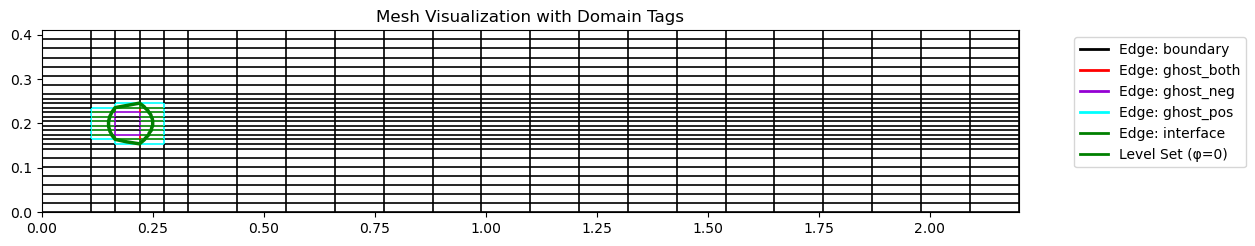

<Axes: title={'center': 'Mesh Visualization with Domain Tags'}>

In [8]:
from pycutfem.io.visualization import plot_mesh_2
fig, ax = plt.subplots(figsize=(15, 30))
plot_mesh_2(mesh, ax=ax, level_set=level_set, show=True, 
              plot_nodes=False, elem_tags=False, edge_colors=True, plot_interface=False,resolution=300)

In [9]:
# ============================================================================
#    3. UFL FORMULATION WITH GHOST PENALTY
# ============================================================================
print("\n--- Defining the UFL weak form for Navier-Stokes with ghost penalty ---")

# --- Function Spaces and Functions ---
velocity_fluid_space = FunctionSpace(name="velocity_fluid", field_names=['u_pos_x', 'u_pos_y'],dim=1, side='+')
pressure_fluid_space = FunctionSpace(name="pressure_fluid", field_names=['p_pos_'], dim=0, side='+')
velocity_solid_space = FunctionSpace(name="velocity_solid", field_names=['vs_neg_x', 'vs_neg_y'], dim=1, side='-')
displacement_space = FunctionSpace(name="displacement", field_names=['d_neg_x', 'd_neg_y'], dim=1, side='-')
# Trial and Test functions
du_f = VectorTrialFunction(space=velocity_fluid_space, dof_handler=dof_handler)
dp_f = TrialFunction(name='trial_pressure_fluid', field_name='p_pos_', dof_handler=dof_handler, side='+')
du_s = VectorTrialFunction(space=velocity_solid_space, dof_handler=dof_handler)
ddisp_s = VectorTrialFunction(space=displacement_space, dof_handler=dof_handler)
test_vel_f = VectorTestFunction(space=velocity_fluid_space, dof_handler=dof_handler)
test_q_f = TestFunction(name='test_pressure_fluid', field_name='p_pos_', dof_handler=dof_handler, side='+')
test_vel_s = VectorTestFunction(space=velocity_solid_space, dof_handler=dof_handler)
test_disp_s = VectorTestFunction(space=displacement_space, dof_handler=dof_handler)

# Solution functions at current (k) and previous (n) time steps
uf_k = VectorFunction(name="u_f_k", field_names=['u_pos_x', 'u_pos_y'], dof_handler=dof_handler, side='+')
pf_k = Function(name="p_f_k", field_name='p_pos_', dof_handler=dof_handler, side='+')
uf_n = VectorFunction(name="u_f_n", field_names=['u_pos_x', 'u_pos_y'], dof_handler=dof_handler, side='+')
pf_n = Function(name="p_f_n", field_name='p_pos_', dof_handler=dof_handler, side='+')
us_k = VectorFunction(name="u_s_k", field_names=['vs_neg_x', 'vs_neg_y'], dof_handler=dof_handler, side='-')
us_n = VectorFunction(name="u_s_n", field_names=['vs_neg_x', 'vs_neg_y'], dof_handler=dof_handler, side='-')
disp_k = VectorFunction(name="disp_k", field_names=['d_neg_x', 'd_neg_y'], dof_handler=dof_handler, side='-')
disp_n = VectorFunction(name="disp_n", field_names=['d_neg_x', 'd_neg_y'], dof_handler=dof_handler, side='-')

# --- Parameters ---
dt = Constant(0.2)
theta = Constant(1.0) # Crank-Nicolson
mu_f_const = Constant(mu_f)
rho_f_const = Constant(rho_f)
rho_s_const = Constant(rho_s)
mu_s = Constant(_mu_s) # Lame's second parameter for solid
lambda_s = Constant(_lambda_s)  # Lame's first parameter for solid

uf_k.nodal_values.fill(0.0); pf_k.nodal_values.fill(0.0)
uf_n.nodal_values.fill(0.0); pf_n.nodal_values.fill(0.0)
us_k.nodal_values.fill(0.0); us_n.nodal_values.fill(0.0)
disp_k.nodal_values.fill(0.0); disp_n.nodal_values.fill(0.0)
dof_handler.apply_bcs(bcs, uf_n, pf_n, us_n, disp_n)


--- Defining the UFL weak form for Navier-Stokes with ghost penalty ---


Plotting all components of 'u_f_n' as separate contour plots...


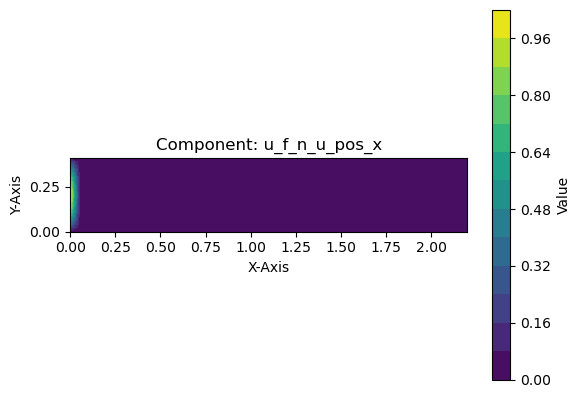

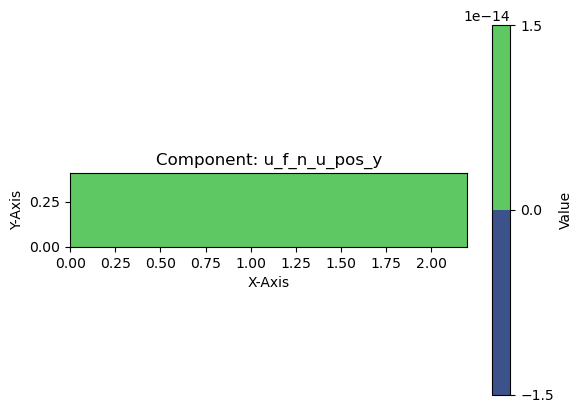

In [10]:
uf_n.plot()

In [11]:
from pycutfem.ufl.expressions import (
    Derivative, FacetNormal, trace, Jump, Hessian,
    Pos, Neg, ElementWiseConstant, restrict,
)

n = FacetNormal()                    # vector expression (n_x, n_y)

def _dn(expr):
    Dx = Derivative(expr, 1, 0)
    Dy = Derivative(expr, 0, 1)
    _ = Dx + Dy
    return n[0]*Dx + n[1]*Dy

def grad_inner(u, v):
    if getattr(u, "num_components", 1) == 1:
        return _dn(u) * _dn(v)
    if u.num_components == v.num_components == 2:
        return _dn(u[0]) * _dn(v[0]) + _dn(u[1]) * _dn(v[1])
    raise ValueError("grad_inner supports only scalars or 2-D vectors.")

def hessian_inner(u, v):
    if getattr(u, "num_components", 1) == 1:
        return _hess_comp(u, v)
    return sum(_hess_comp(u[i], v[i]) for i in range(u.num_components))

def _hess_comp(a, b):
    return (
        Derivative(a, 2, 0) * Derivative(b, 2, 0)
        + 2 * Derivative(a, 1, 1) * Derivative(b, 1, 1)
        + Derivative(a, 0, 2) * Derivative(b, 0, 2)
    )

def grad_inner_jump(u, v):
    a = dot(jump(grad(u)), n)
    b = dot(jump(grad(v)), n)
    return inner(a, b)

def hess_inner_jump(u, v):
    a = dot(n, dot(jump(Hessian(u)), n))
    b = dot(n, dot(jump(Hessian(v)), n))
    return inner(a, b)

qvol = 6
dx_fluid = dx(
    defined_on=fluid_interface_domain,
    level_set=level_set,
    metadata={"q": qvol, "side": "+"},
)
dx_solid = dx(
    defined_on=solid_interface_domain,
    level_set=level_set,
    metadata={"q": qvol, "side": "-"},
)
dΓ = dInterface(
    defined_on=mesh.element_bitset("cut"),
    level_set=level_set,
    metadata={"q": qvol + 2, "derivs": {(0, 0), (0, 1), (1, 0)}},
)
if hessian_ghost_enabled:
    dG_fluid = dGhost(
        defined_on=fluid_ghost_edges,
        level_set=level_set,
        metadata={"q": qvol, "derivs": {(0, 0), (0, 1), (1, 0), (2, 0), (0, 2), (1, 1)}},
    )
    dG_solid = dGhost(
        defined_on=solid_ghost_edges,
        level_set=level_set,
        metadata={"q": qvol, "derivs": {(0, 0), (0, 1), (1, 0), (2, 0), (0, 2), (1, 1)}},
    )
else:
    dG_fluid = dGhost(
        defined_on=fluid_ghost_edges,
        level_set=level_set,
        metadata={"q": qvol, "derivs": {(0, 1), (1, 0)}},
    )
    dG_solid = dGhost(
        defined_on=solid_ghost_edges,
        level_set=level_set,
        metadata={"q": qvol, "derivs": {(0, 1), (1, 0)}},
    )

cell_h = CellDiameter()
beta_N = Constant(20.0 * poly_order**2)

theta_min = 1.0e-3
theta_pos_vals = np.clip(hansbo_cut_ratio(mesh, level_set, side="+"), theta_min, 1.0)
theta_neg_vals = np.clip(hansbo_cut_ratio(mesh, level_set, side="-"), theta_min, 1.0)
kappa_pos = Pos(ElementWiseConstant(theta_pos_vals))
kappa_neg = Neg(ElementWiseConstant(theta_neg_vals))

du_f_R = restrict(du_f, has_pos)
dp_f_R = restrict(dp_f, has_pos)
test_vel_f_R = restrict(test_vel_f, has_pos)
test_q_f_R = restrict(test_q_f, has_pos)
uf_k_R = restrict(uf_k, has_pos)
uf_n_R = restrict(uf_n, has_pos)
pf_k_R = restrict(pf_k, has_pos)
pf_n_R = restrict(pf_n, has_pos)

du_s_R = restrict(du_s, has_neg)
ddisp_s_R = restrict(ddisp_s, has_neg)
test_vel_s_R = restrict(test_vel_s, has_neg)
test_disp_s_R = restrict(test_disp_s, has_neg)
us_k_R = restrict(us_k, has_neg)
us_n_R = restrict(us_n, has_neg)
disp_k_R = restrict(disp_k, has_neg)
disp_n_R = restrict(disp_n, has_neg)

I2 = Constant(np.eye(2))

def epsilon_f(u):
    return 0.5 * (grad(u) + grad(u).T)

def epsilon_s_linear_L(disp, disp_k):
    return 0.5 * (
        grad(disp) + grad(disp).T
        + dot(grad(disp).T, grad(disp_k))
        + dot(grad(disp_k).T, grad(disp))
    )

def epsilon_s_linear_R(disp_k):
    return 0.5 * (
        grad(disp_k) + grad(disp_k).T
        + dot(grad(disp_k).T, grad(disp_k))
    )

def sigma_s_linear_weak_L(ddisp, disp_k, grad_v_test):
    eps = epsilon_s_linear_L(ddisp, disp_k)
    return 2.0 * mu_s * inner(eps, grad_v_test) + lambda_s * trace(eps) * trace(grad_v_test)

def sigma_s_linear_weak_R(disp_k, grad_v_test):
    eps = epsilon_s_linear_R(disp_k)
    return 2.0 * mu_s * inner(eps, grad_v_test) + lambda_s * trace(eps) * trace(grad_v_test)

def traction_fluid(u_vec, p_scal):
    return 2.0 * mu_f_const * dot(epsilon_f(u_vec), n) - p_scal * n

def traction_solid_L(disp_inc, disp_ref):
    eps = epsilon_s_linear_L(disp_inc, disp_ref)
    sigma = 2.0 * mu_s * eps + lambda_s * trace(eps) * I2
    return dot(sigma, n)

def traction_solid_R(disp_ref):
    eps = epsilon_s_linear_R(disp_ref)
    sigma = 2.0 * mu_s * eps + lambda_s * trace(eps) * I2
    return dot(sigma, n)

def sigma_dot_n_v(u_vec, p_scal, v_test):
    a = dot(grad(u_vec), n)
    b = dot(grad(u_vec).T, n)
    return mu_f * dot(a + b, v_test) - p_scal * dot(v_test, n)

jump_vel_trial = Jump(du_f, du_s)
jump_vel_test = Jump(test_vel_f, test_vel_s)
jump_vel_res = Jump(uf_k, us_k)

avg_flux_trial = (
    kappa_pos * traction_fluid(Pos(du_f), Pos(dp_f))
    + kappa_neg * traction_solid_L(Neg(ddisp_s), Neg(disp_k))
)

avg_flux_test = (
    kappa_pos * traction_fluid(Pos(test_vel_f), Pos(test_q_f))
    + kappa_neg * traction_solid_L(Neg(test_disp_s), Neg(disp_k))
)

avg_flux_res = (
    kappa_pos * traction_fluid(Pos(uf_k), Pos(pf_k))
    + kappa_neg * traction_solid_R(Neg(disp_k))
)

J_int = (
    -dot(avg_flux_trial, jump_vel_test)
    - dot(avg_flux_test, jump_vel_trial)
    + (beta_N * mu_f / cell_h) * dot(jump_vel_trial, jump_vel_test)
) * dΓ

R_int = (
    -dot(avg_flux_res, jump_vel_test)
    - dot(avg_flux_test, jump_vel_res)
    + (beta_N * mu_f / cell_h) * dot(jump_vel_res, jump_vel_test)
) * dΓ

a_vol_f = (
    rho_f_const / dt * dot(du_f_R, test_vel_f_R)
    + theta * rho_f_const * dot(dot(grad(uf_k_R), du_f_R), test_vel_f_R)
    + theta * rho_f_const * dot(dot(grad(du_f_R), uf_k_R), test_vel_f_R)
    + theta * mu_f_const * inner(grad(du_f_R), grad(test_vel_f_R))
    - dp_f_R * div(test_vel_f_R)
    + test_q_f_R * div(du_f_R)
) * dx_fluid

r_vol_f = (
    rho_f_const * dot(uf_k_R - uf_n_R, test_vel_f_R) / dt
    + theta * rho_f_const * dot(dot(grad(uf_k_R), uf_k_R), test_vel_f_R)
    + (1 - theta) * rho_f_const * dot(dot(grad(uf_n_R), uf_n_R), test_vel_f_R)
    + theta * mu_f_const * inner(grad(uf_k_R), grad(test_vel_f_R))
    + (1 - theta) * mu_f_const * inner(grad(uf_n_R), grad(test_vel_f_R))
    - pf_k_R * div(test_vel_f_R)
    + test_q_f_R * div(uf_k_R)
) * dx_fluid

a_vol_s = (
    rho_s * dot(du_s_R, test_vel_s_R) / dt
    + theta * sigma_s_linear_weak_L(ddisp_s_R, disp_k_R, grad(test_vel_s_R))
) * dx_solid

r_vol_s = (
    rho_s * dot(us_k_R - us_n_R, test_vel_s_R) / dt
    + theta * sigma_s_linear_weak_R(disp_k_R, grad(test_vel_s_R))
    + (1 - theta) * sigma_s_linear_weak_R(disp_n_R, grad(test_vel_s_R))
) * dx_solid

a_svc = (
    dot(ddisp_s_R, test_disp_s_R) / dt
    - theta * dot(du_s_R, test_disp_s_R)
) * dx_solid

r_svc = (
    dot(disp_k_R - disp_n_R, test_disp_s_R) / dt
    - theta * dot(us_k_R, test_disp_s_R)
    - (1 - theta) * dot(us_n_R, test_disp_s_R)
) * dx_solid

penalty_val = 1e-3
penalty_grad = 1e-3
penalty_hess = 1e-3
gamma_v = Constant(penalty_val * poly_order**2)
gamma_v_grad = Constant(penalty_grad * poly_order**2)
gamma_p = Constant(penalty_val * poly_order)
gama_p_grad = Constant(penalty_grad * poly_order)

def g_v_f(gamma, phi_1, phi_2):
    if hessian_ghost_enabled:
        return gamma * (
            cell_h * grad_inner_jump(phi_1, phi_2)
            + cell_h**3.0 / 4.0 * hess_inner_jump(phi_1, phi_2)
        )
    return gamma * (cell_h * grad_inner_jump(phi_1, phi_2))

def g_p(gamma, phi_1, phi_2):
    return gamma * (cell_h**3.0 * grad_inner_jump(phi_1, phi_2))

def g_v_s(gamma, phi_1, phi_2):
    return gamma * (cell_h**3.0 * grad_inner_jump(phi_1, phi_2))

def g_disp_s(gamma, phi_1, phi_2):
    return gamma * (cell_h * grad_inner_jump(phi_1, phi_2))

a_stab = (
    (
        Constant(2.0) * mu_f_const * g_v_f(gamma_v, du_f_R, test_vel_f_R)
        + g_p(gamma_p, dp_f_R, test_q_f_R)
    )
    * dG_fluid
    + (
        rho_s_const * g_v_s(gamma_v, du_s_R, test_vel_s_R)
        + Constant(2.0) * mu_s * g_disp_s(gamma_v_grad, ddisp_s_R, test_disp_s_R)
    )
    * dG_solid
)

r_stab = (
    (
        Constant(2.0) * mu_f_const * g_v_f(gamma_v, uf_k_R, test_vel_f_R)
        + g_p(gamma_p, pf_k_R, test_q_f_R)
    )
    * dG_fluid
    + (
        rho_s_const * g_v_s(gamma_v, us_k_R, test_vel_s_R)
        + Constant(2.0) * mu_s * g_disp_s(gamma_v_grad, disp_k_R, test_disp_s_R)
    )
    * dG_solid
)

jacobian_form = a_vol_f + J_int + a_vol_s + a_svc + a_stab
residual_form = r_vol_f + R_int + r_vol_s + r_svc + r_stab



In [12]:
!rm ~/.cache/pycutfem_jit/*

rm: cannot remove '/home/jamal/.cache/pycutfem_jit/__pycache__': Is a directory


In [13]:
# from pycutfem.ufl.forms import assemble_form
# K,F=assemble_form(jacobian_form==-residual_form, dof_handler=dof_handler, bcs=bcs_homog)
# print(np.linalg.norm(F, ord=np.inf))

In [14]:
from pycutfem.solvers.nonlinear_solver import NewtonSolver, NewtonParameters, TimeStepperParameters, AdamNewtonSolver
from pycutfem.solvers.aainhb_solver import AAINHBSolver           # or get_solver("aainhb")

uf_k.nodal_values.fill(0.0); pf_k.nodal_values.fill(0.0)
uf_n.nodal_values.fill(0.0); pf_n.nodal_values.fill(0.0)
us_k.nodal_values.fill(1.0); us_n.nodal_values.fill(0.0)
disp_k.nodal_values.fill(2.0); disp_n.nodal_values.fill(0.0)
dof_handler.apply_bcs(bcs, uf_n, pf_n, us_n, disp_n)
dof_handler.apply_bcs(bcs, uf_k, pf_k, us_k, disp_k)

# build residual_form, jacobian_form, dof_handler, mixed_element, bcs, bcs_homog …
time_params = TimeStepperParameters(dt=dt.value,max_steps=36 ,stop_on_steady=True, steady_tol=1e-6, theta= theta.value)

solver = NewtonSolver(
    residual_form, jacobian_form,
    dof_handler=dof_handler,
    mixed_element=mixed_element,
    bcs=bcs, bcs_homog=bcs_homog,
    newton_params=NewtonParameters(newton_tol=1e-6, line_search=True),
)
# primary unknowns
functions      = [uf_k, pf_k, us_k, disp_k]
prev_functions = [uf_n, pf_n, us_n, disp_n]
# solver = AdamNewtonSolver(
#     residual_form, jacobian_form,
#     dof_handler=dof_handler,
#     mixed_element=mixed_element,
#     bcs=bcs, bcs_homog=bcs_homog,
#     newton_params=NewtonParameters(newton_tol=1e-6)
# )
# solver = AAINHBSolver(
#     residual_form, jacobian_form,
#     dof_handler=dof_handler,
#     mixed_element=mixed_element,
#     bcs=bcs, bcs_homog=bcs_homog,
#     newton_params=NewtonParameters(newton_tol=1e-6),
# )



solver.solve_time_interval(functions=functions,
                           prev_functions= prev_functions,
                           time_params=time_params,)

JIT cache miss → compiling _pycutfem_kernel_d1e9a2233538258538179999a3ff4175eb79b6c0e4953ef73a1321446126ed04.py
JIT cache miss → compiling _pycutfem_kernel_455eaf83a41f2a6fc87b197eedf1b887e92d754a16030e9e3e6a7c891f0a2b2e.py
JIT cache miss → compiling _pycutfem_kernel_a9efe911cd5cb43445b2f618542f4ee271eea515e276ebdd348c33c5f53c883d.py
JIT cache miss → compiling _pycutfem_kernel_ac6e258e7f045c7ec8181d4567ccd7ea11a5fec686b83115d1f0ab66d6682011.py
JIT cache miss → compiling _pycutfem_kernel_9d5510016cfa36f6eb54fd760c062478704ac9c0a3c49d3443b9d07f930e02b1.py
JIT cache miss → compiling _pycutfem_kernel_e6e3680ffb341c405d06902be5a7d679e5bc2d037af11722e1384cc43b73b225.py
JIT cache miss → compiling _pycutfem_kernel_8b74a2d666982409df9c99692690bbd6ddd4784a058be94d3a629fe12cfdfb27.py
JIT cache miss → compiling _pycutfem_kernel_aa8933f0af9b1858095d01137b7e5a43ec17b061b75e73b10530cad1c19fb2bf.py
JIT cache miss → compiling _pycutfem_kernel_7501c33b65863876be3f0b2b931220ddf2dcbc1fa8ae08926069a0e5da69

KeyboardInterrupt: 

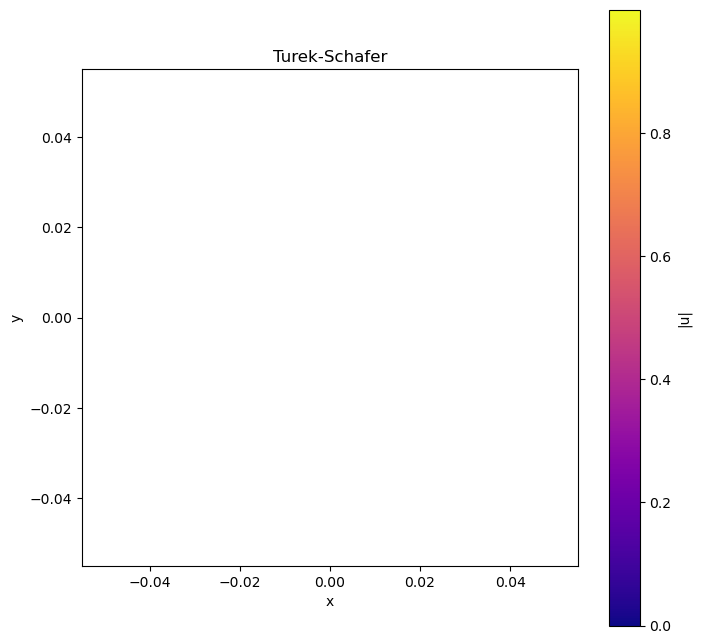

In [ ]:
uf_n.plot(kind="streamline",
         density=4.0,
         linewidth=0.8,
         cmap="plasma",
         title="Turek-Schafer",background = False)